In [173]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

%matplotlib notebook

In [174]:
def initialize_node_properties(graph):
    """
    Adds random soil depth and set oxygen property
    """
    for node in graph.nodes():   
        depth = np.random.random() * SOIL_DEPTH
        graph.nodes[node]['depth'] = depth
        graph.nodes[node]['o2'] = False # Initialization
        
    return 0

def fill_with_air(graph, surface_nodes):
    """
    All nodes connected to a surface node (depth = 0) get o2 = True.
    Modifies graph in place.
    Returns air filled nodes sorted list
    """
    for node in graph.nodes():
        graph.nodes[node]['o2'] = False # Reinitialize
    
    air_filled_nodes = set()
    for i in surface_nodes:
        air_filled_nodes.update(nx.algorithms.descendants(graph, i))
    
    for af_node in air_filled_nodes:
        graph.nodes[node]['o2'] = True
    
    return list(air_filled_nodes)

def remove_waterlogged(graph, water_table, surface_nodes):
    """
    Removes the nodes that are deeper than water_table.
    Returns removed water nodes.
    """
    water_nodes = [node for node,attr in graph.nodes(data=True) if attr['depth'] > water_table]
    water_nodes = list( set(water_nodes) - set(surface_nodes)) # Do not remove surface nodes. Otherwise, cannot fill them with air!
    graph.remove_nodes_from(water_nodes)
    
    return water_nodes


In [175]:
"""
Define networks
"""

# Parameters
N_NODES = 1000
N_EDGES = 1000

SOIL_DEPTH = 100

TIMESTEPS = 100
dt = SOIL_DEPTH/TIMESTEPS


# Create graphs
g_complete = nx.complete_graph(N_NODES); g_complete.name = 'complete'

lattice_size = int(N_NODES**(1/3)) + 1
g_lattice = nx.grid_graph(dim=[lattice_size, lattice_size, lattice_size]); g_lattice.name = 'lattice'

R_ARY = 2 # Number of children of each node for the tree
g_rary_tree = nx.full_rary_tree(n=N_NODES, r=R_ARY); g_rary_tree.name = 'full tree'

g_random_tree = nx.random_tree(n=N_NODES); g_random_tree.name = 'random tree'

g_random = nx.gnm_random_graph(n=N_NODES, m=N_EDGES); g_random.name = 'random'

PREFERENTIAL_NEW_EDGES = int(N_NODES/N_EDGES) # this makes same number of edges as the random, if N_EDGES is a multiple of N_NODES
g_barabasi_albert = nx.barabasi_albert_graph(n=N_NODES, m=PREFERENTIAL_NEW_EDGES); g_barabasi_albert.name = 'preferential attachment'

graphs = [g_lattice, g_random, g_barabasi_albert, g_rary_tree, g_random_tree, g_complete]
# Add properties to nodes: depth, o2.
surface_nodes = {}



for graph in graphs:
    initialize_node_properties(graph)
    # Compute surface nodes    
    surface_nodes[graph.name] = tuple([node for node,attr in graph.nodes(data=True) if attr['depth'] < SOIL_DEPTH/100.]) # Surface nodes are the 1% closest to the surface
#    surface_nodes[i][1] = tuple(surface_nodes) # surface_nodes don't change

# Lattice graph has a regular spatial structure. Add it by hand.
for node in g_lattice.nodes:
    g_lattice.nodes[node]['depth'] = SOIL_DEPTH/(lattice_size-1) * node[2]
surface_nodes[g_lattice.name] = tuple([node for node in g_lattice.nodes if node[2] == 0])

graph_list = [(i,graph.name) for i,graph in enumerate(graphs)]

wt = SOIL_DEPTH # Water table begins as deep as possible


In [176]:
"""
Dynamics
"""

data_over_time = {}
for graph in graphs:
    data_over_time[graph.name] = []
waterlogged_nodes = {}
air_filled_nodes = {}
wt_values = np.arange(0.0, SOIL_DEPTH, dt) # Water table, measured positively downward from surface. wt=10 means 10 distance units below surface.
wt_values = wt_values[::-1] # Reverse numpy array: water table increases from above to below.

print("#### RAISING WATER TABLE #### \n")

for wt in wt_values:
    print("Water table depth = -{0} m".format(wt/100), end="\r")
    
    for graph in graphs:
        # If a node is waterlogged, its edges are removed.
        waterlogged_nodes[graph.name] = remove_waterlogged(graph, wt, surface_nodes[graph.name])
        # Re-compute which nodes are filled by air. Lattice gets special treatment due to regularity
        if graph.name == 'lattice':
            air_filled_nodes[graph.name] = graph.nodes() # all nodes are filled with air
        else:    
            air_filled_nodes[graph.name] = fill_with_air(graph, surface_nodes[graph.name])
        
        data_over_time[graph.name].append( [len(air_filled_nodes[graph.name])/N_NODES, wt, dt] )


#### RAISING WATER TABLE #### 



<IPython.core.display.Javascript object>


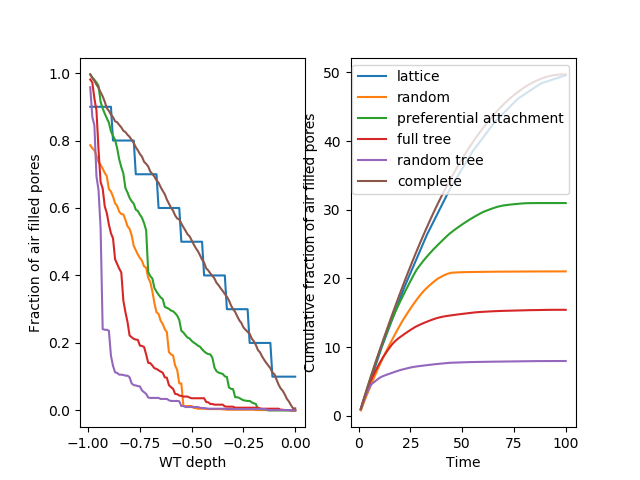

In [180]:
"""
Plots
"""


# 2 y axis, legends
#fig, ax1 = plt.subplots()
#ax1.set_xlabel('time')
#color = 'tab:red'
#ax1.set_ylabel(' ', color=color)
#p1 = ax1.plot(data[:,2], data[:,0], label='air filled pore fraction', color=color)
#
#ax2 = ax1.twinx() # 2nd axes
#color = 'tab:blue'
#ax2.set_ylabel(' ', color=color)
#p2 = ax2.plot(data[:,2], -data[:,1], label='water table depth', color=color)
#
#fig.tight_layout()
#
## All labels in the same legend
#plots = p1 + p2
#labels = [l.get_label() for l in plots]
#ax1.legend(plots, labels, loc=0)

fig, (ax1,ax2) = plt.subplots(1,2)
for graph in graphs:
    data = np.array(data_over_time[graph.name])
    ax1.set_xlabel('WT depth')
    ax1.set_ylabel('Fraction of air filled pores')
    
    ax1.plot(-data[:,1]/100, data[:,0], label=graph.name)
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative fraction of air filled pores')
    
    ax2.plot(-data[:,1] + 100, np.cumsum(data[:,0]), label=graph.name)

## Plot table as well
#network_stats = [[len(graph.edges)] for graph in graphs]
#col_names = ['n_edges']
#row_names = [graph.name for graph in graphs]
#ax.table(cellText=network_stats, rowLabels=row_names, colLabels=col_names)
#
#plt.subplots_adjust(left=0.2, bottom=0.5)

plt.legend()
plt.show()


In [139]:
#for node,attr in g_lattice.nodes(data=True):
    #print(attr['depth'])
len(g_lattice.nodes)

1000

In [47]:
a  = [2, 'a']

In [50]:
b = a + [5]
b

[2, 'a', 5]